In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

# Load the MNIST dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 35291945.12it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2312279.41it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 12099582.38it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2443942.11it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Visualization of the dataset

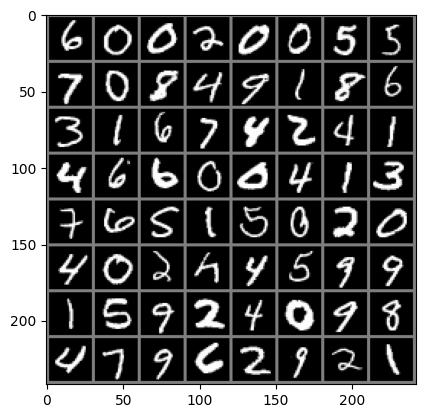

    6     0     0     2     0     0     5     5


In [3]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j].item() for j in range(8)))

# Define the Radial Basis Function Network model

In [16]:
class RBFN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RBFN, self).__init__()
        self.hidden_dim = hidden_dim
        self.centers = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.beta = nn.Parameter(torch.ones(1, hidden_dim) * 1.0)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def kernel_function(self, x):
        # Compute the distance between each input sample and each center
        x = x.unsqueeze(1).expand(-1, self.hidden_dim, -1)
        c = self.centers.unsqueeze(0).expand(x.size(0), -1, -1)
        return torch.exp(-self.beta * torch.sum((x - c) ** 2, dim=2))

    def forward(self, x):
        phi = self.kernel_function(x)
        out = self.linear(phi)
        return F.log_softmax(out, dim=1)

# Initialize the model, loss function, and optimizer

In [17]:
input_dim = 28 * 28  # MNIST images are 28x28 pixels
hidden_dim = 100  # Number of RBF neurons
output_dim = 10  # 10 classes for digits 0-9

model = RBFN(input_dim, hidden_dim, output_dim)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop

In [18]:
num_epochs = 10
losses = []
accuracies = []
for epoch in range(num_epochs):
    epoch_loss = 0
    correct = 0
    total = 0
    for data in train_loader:
        images, labels = data
        images = images.view(-1, 28*28)  # Flatten the images

        optimizer.zero_grad()
        outputs = model(images)
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = epoch_loss / len(train_loader)
    accuracy = correct / total
    losses.append(avg_loss)
    accuracies.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/10], Loss: 2.3025, Accuracy: 0.1124
Epoch [2/10], Loss: 2.3014, Accuracy: 0.1124
Epoch [3/10], Loss: 2.3013, Accuracy: 0.1124
Epoch [4/10], Loss: 2.3012, Accuracy: 0.1124
Epoch [5/10], Loss: 2.3012, Accuracy: 0.1124
Epoch [6/10], Loss: 2.3012, Accuracy: 0.1124
Epoch [7/10], Loss: 2.3012, Accuracy: 0.1124
Epoch [8/10], Loss: 2.3012, Accuracy: 0.1124
Epoch [9/10], Loss: 2.3012, Accuracy: 0.1124
Epoch [10/10], Loss: 2.3012, Accuracy: 0.1124


# Visualization of training loss and accuracy

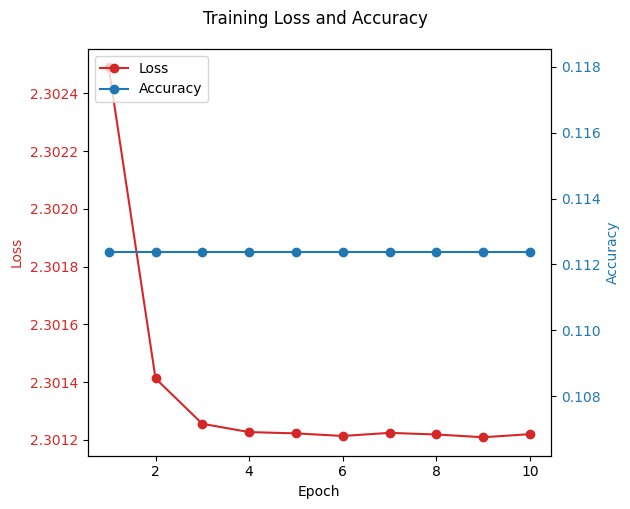

In [22]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, num_epochs + 1), losses, marker='o', color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(range(1, num_epochs + 1), accuracies, marker='o', color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.suptitle('Training Loss and Accuracy', y=1.05)

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

# Evaluation

In [20]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = correct / total

print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.1135


# Visualization of some test images and their predictions

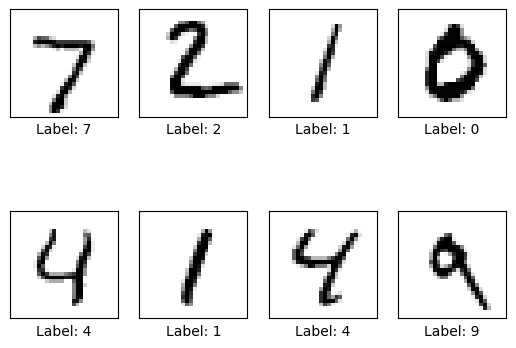

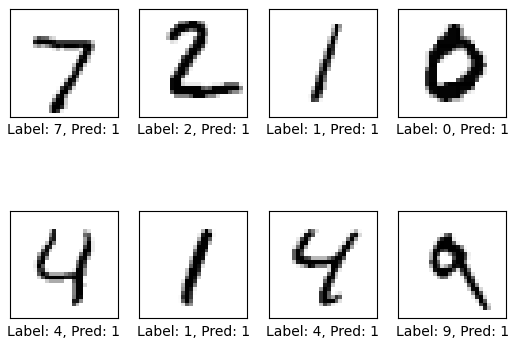

In [23]:
def plot_images(images, labels, predictions=None):
    plt.figure()
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].reshape(28, 28), cmap=plt.cm.binary)
        if predictions is None:
            plt.xlabel(f"Label: {labels[i]}")
        else:
            plt.xlabel(f"Label: {labels[i]}, Pred: {predictions[i]}")
    plt.show()

# Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Show images with ground truth labels
plot_images(images.numpy(), labels.numpy())

# Predict labels for the sample images
images_flat = images.view(-1, 28*28)
outputs = model(images_flat)
_, predicted = torch.max(outputs, 1)

# Show images with predicted labels
plot_images(images.numpy(), labels.numpy(), predicted.numpy())